In [1]:
import pandas as pd
import numpy as np
import datetime
import quandl
import matplotlib.pyplot as plt
import ast
import datetime

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, cross_validation, svm
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

quandl.ApiConfig.api_key = "i2eKHKvqXVLFxr1aAgDU"

/Users/haokun/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/haokun/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [283]:
df = quandl.get("EOD/SBUX", start_date='2018-01-01', end_date='2018-11-30')
data = df.sort_index(ascending=True, axis=0)
data.reset_index(level=0, inplace=True)

In [284]:
sentiment = pd.read_csv("starbucks.csv", header=None)
sentiment.columns = ['Date', 'Sentiment']
table = {}
for index, row in sentiment.iterrows():
    date = row['Date']
    sentiment_score = ast.literal_eval(row['Sentiment'])
    table[date] = [int(sentiment_score[0]), float(sentiment_score[1]), float(sentiment_score[2])]

In [285]:
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Adj_Close', 'Sentiment', 'TotalTweets'])
# new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Adj_Close'])
# new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Adj_Close', 'Sentiment'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Adj_Close'][i] = data['Adj_Close'][i]
    
#     dateStr = new_data['Date'][i].strftime('%Y-%m-%d')
#     if dateStr in table:
#         sentiment = table[dateStr]
#         new_data['Sentiment'][i] = sentiment[0] * (sentiment[1] - 0.5)
#     else:
#         new_data['Sentiment'][i] = 0.5
    
    dateStr = new_data['Date'][i].strftime('%Y-%m-%d')
    if dateStr in table:
        sentiment = table[dateStr]
        new_data['Sentiment'][i] =  sentiment[1]
        new_data['TotalTweets'][i] =  sentiment[0]
    else:
        new_data['Sentiment'][i] = 0.5
        new_data['TotalTweets'][i] = 0

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
print(new_data.tail(10))

           Adj_Close Sentiment
Date                          
2018-11-16     68.16        -8
2018-11-19     67.91         4
2018-11-20     67.18        14
2018-11-21     66.77        -3
2018-11-23      65.7      14.5
2018-11-26     65.69       1.5
2018-11-27     66.08       3.5
2018-11-28     66.82         6
2018-11-29     66.88       0.5
2018-11-30     66.72       0.5


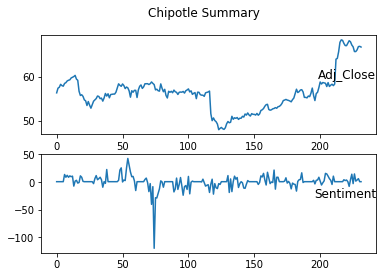

In [286]:
values = new_data.values
groups = [0, 1, 2]
i = 1
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(new_data.columns[group], y=0.5, loc='right')
    i += 1
plt.suptitle("Chipotle Summary")
plt.savefig('Chipotle-summary.png')
plt.show()

In [287]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    colNames = list(new_data.columns.values)
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (colNames[j%3], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (colNames[j%3])) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

values = new_data.values
values = values.astype('float32')
# normalize value
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 5, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-1]], axis=1, inplace=True)
print(reframed.tail())

     Adj_Close(t-5)  Sentiment(t-5)  Adj_Close(t-4)  Sentiment(t-4)  \
227        0.990545        0.689231        0.978294        0.763077   
228        0.978294        0.763077        0.942522        0.824615   
229        0.942522        0.824615        0.922431        0.720000   
230        0.922431        0.720000        0.869998        0.827692   
231        0.869998        0.827692        0.869509        0.747692   

     Adj_Close(t-3)  Sentiment(t-3)  Adj_Close(t-2)  Sentiment(t-2)  \
227        0.942522        0.824615        0.922431        0.720000   
228        0.922431        0.720000        0.869998        0.827692   
229        0.869998        0.827692        0.869509        0.747692   
230        0.869509        0.747692        0.888619        0.760000   
231        0.888619        0.760000        0.924881        0.775385   

     Adj_Close(t-1)  Sentiment(t-1)  Adj_Close(t)  
227        0.869998        0.827692      0.869509  
228        0.869509        0.747692      0

In [290]:
# split into train and test sets
values = reframed.values
# offset first 5 rows
train = values[:180-5, :]
test = values[180-5:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(175, 1, 10) (175,) (52, 1, 10) (52,)


Train on 175 samples, validate on 52 samples
Epoch 1/50
 - 4s - loss: 0.2640 - val_loss: 0.3099
Epoch 2/50
 - 0s - loss: 0.1242 - val_loss: 0.1282
Epoch 3/50
 - 0s - loss: 0.0749 - val_loss: 0.1932
Epoch 4/50
 - 0s - loss: 0.0880 - val_loss: 0.1533
Epoch 5/50
 - 0s - loss: 0.0738 - val_loss: 0.1213
Epoch 6/50
 - 0s - loss: 0.0622 - val_loss: 0.1113
Epoch 7/50
 - 0s - loss: 0.0565 - val_loss: 0.0905
Epoch 8/50
 - 0s - loss: 0.0454 - val_loss: 0.0787
Epoch 9/50
 - 0s - loss: 0.0409 - val_loss: 0.0599
Epoch 10/50
 - 0s - loss: 0.0362 - val_loss: 0.0597
Epoch 11/50
 - 0s - loss: 0.0358 - val_loss: 0.0579
Epoch 12/50
 - 0s - loss: 0.0353 - val_loss: 0.0604
Epoch 13/50
 - 0s - loss: 0.0360 - val_loss: 0.0656
Epoch 14/50
 - 0s - loss: 0.0374 - val_loss: 0.0628
Epoch 15/50
 - 0s - loss: 0.0362 - val_loss: 0.0581
Epoch 16/50
 - 0s - loss: 0.0348 - val_loss: 0.0566
Epoch 17/50
 - 0s - loss: 0.0346 - val_loss: 0.0614
Epoch 18/50
 - 0s - loss: 0.0355 - val_loss: 0.0631
Epoch 19/50
 - 0s - loss: 0.

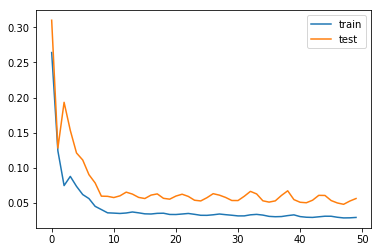

In [291]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
# model.add(Dropout(0.1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [292]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = inv_yhat[:,:3]
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = inv_y[:,:3]
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# # calculate RMSE

In [293]:
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat)) / inv_y.mean()
print('Test RMSE: %.3f' % (rmse*100) + '%')

Test RMSE: 2.754%


In [294]:
# try to see if prediction can guess next price is up or down
hit = 0
miss = 0
for i in range(1, len(inv_y)):
    actualSign = inv_y[i] - inv_y[i-1]
    predictSign = inv_yhat[i] - inv_yhat[i-1]
    if actualSign * predictSign > 0:
        hit += 1
    else:
        miss += 1
    
print('Test trend prediction accuracy: %.3f' % (hit*100/(hit+miss)) + "%")

Test trend prediction accuracy: 56.863%


In [ ]:
train = new_data[:180]
valid = new_data[180:]
valid['Predictions'] = inv_yhat

plt.plot(train['Adj_Close'], label = "Training actual")
plt.plot(valid[['Adj_Close']], label="Testing actual")
plt.plot(valid[['Predictions']], label="Testing predction")
plt.legend(loc='lower right')
plt.xticks(['2018-01-01','2018-11-30'], ['2018-01-01','2018-11-30'])
plt.title('Starbucks Stock Price Prediction with Sentiment', fontsize=15)

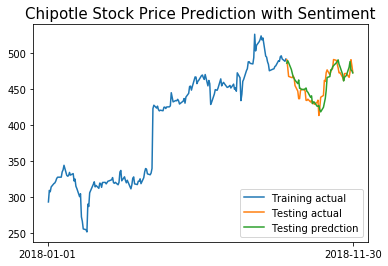

In [236]:
plt.savefig('Starbucks-with-sentiment.png')
plt.show()